```text
SPDX-License-Identifier: PolyForm-Noncommercial-1.0.0
Autor: Bruno Francisco Barra Atarama
Institución:
  Departamento de Ingeniería Aeroespacial
  Facultad de Ingeniería
  Universidad Nacional de La Plata
Año: 2025
Licencia: PolyForm Noncommercial License 1.0.0
```

**Licencia:** ver [LICENSE](../LICENSE).

# Ejemplo: básico de uso

En este ejemplo se muestra cómo configurar una simulación donde se pueden obtener los coeficientes aerodinámicos de un perfil para distintos ángulos de ataque. También, se contrastará lo obtenido contra resultados de [*XFoil*](https://web.mit.edu/drela/Public/web/xfoil/).

Puede notarse que:

- En una sucesión de experimentos estacionarios (por ejemplo, un barrido de ángulos de ataque), la "cinemática" puede entenderse como una mera sucesión de posiciones, sin intervención del tiempo.
- Continuando lo anterior, en estos casos el vector `MP2D.t` no debe satisfacer condiciones temporales y puede guardar una variable particular del experimento (numérica, en este caso el ángulo de ataque). Esto permite reutilizar los métodos de graficación y, por ejemplo, lo que hubiera sido $C_l$ vs. $t$, ahora se convierte en la polar $C_l$ vs. $\alpha$.


## Bibliotecas y módulos

A continuación, se muestra qué bibliotecas se importan para este ejemplo particular.

El módulo de tipado se recomienda utilizar para aprovechar las ayudas documentadas, sobre todo en los primeros usos.

In [ ]:
%matplotlib inline
# Para gráficos interactivos en el notebook. # Para utilizar, instalar ipympl con `pip install ipympl`
#%matplotlib widget    

# Bibliotecas generales
import numpy as np                          # Para hacer operaciones matemáticas
import matplotlib, matplotlib.pyplot as plt # Para graficar
import warnings
from scipy.linalg import LinAlgWarning

# Módulos propios

# Funcionales
from src.MP2D import MP2D
from src import Cinematicas
from src.Importacion import discretizarPerfil, polaresXFoil

# Tipado
from src import Tipos

## Importación del perfil y construcción del panelado

En este caso se utiliza el formato `'selig'` (por defecto), pero también puede utilizarse `'lednicer'`.

In [7]:
c = 1       # Cuerda del perfil. Es opcional para la importación, pero se la define para ser consistente con la longitud de referencia.
nIntraExtra = 200
r_xy = discretizarPerfil(
    ruta = 'rec/perfiles/NACA23012_selig.txt',
    cuerda=c,
    nIntrados=nIntraExtra,
    nExtrados=nIntraExtra,
    formato='selig',
)

## Configuración de los experimentos

En primer lugar, se definen los $\alpha$ a evaluar, así como las condiciones de referencia.

Luego, se desplaza el perfil para ubicar el cuarto de cuerda en el origen, para poder generar fácilmente el vector de toma de momentos y obtener el $C_{m, c/4}$.

In [8]:
# -----------
# Condiciones
# -----------
alfa = np.arange(-7, 16)
V = 1

refConfig: Tipos.RefConfig = {
    'l' : c,
    'V' : V,          
    # 'P' : 101325,     # Se completan automáticamente con los valores por defecto, que son los mostrados.
    # 'rho' : 1.225,
}

# -------------------------
# Desplazamiento del perfil
# -------------------------

r_xy = Cinematicas.moverCoordenadas(r_xy, Dx = - 0.25 * c)

# ---------------------
# Cinemática del sólido
# ---------------------

AOAParams : Tipos.AOAParams = {
    'alfa' : alfa,
    'r_xy' : r_xy,
    'V' : V,
}

cinematica = Cinematicas.cinematica('aoa', AOAParams)

# -------------------------
# Punto de toma de momentos
# -------------------------

RMParams : Tipos.RMParams = {'rep' : len(alfa)}     # Al no especificar `'RM'` se devuelve el origen `len(alfa)` veces.

RM = Cinematicas.RM('RM', RMParams)

## Simulación

In [9]:
# Se configura el simulador
mpConfig: Tipos.MPConfig = {
    'estacionario' : True,
    'vorticeArranque' : True,
    'nombres' : ['MP2D'],
    'rotulo_t' : 'AOA [°]'
}

mp = MP2D(cinematica, RM, mpConfig, refConfig)

# Se simula
mp.simular()

Simulando: 100%|██████████| 23/23 [00:00<00:00, 40.24 pasos/s]


## Velocidades relativas en la superficie

Las velocidades mostradas son las inducidas en los puntos de colocación, sustrayendo la velocidad cinemática.

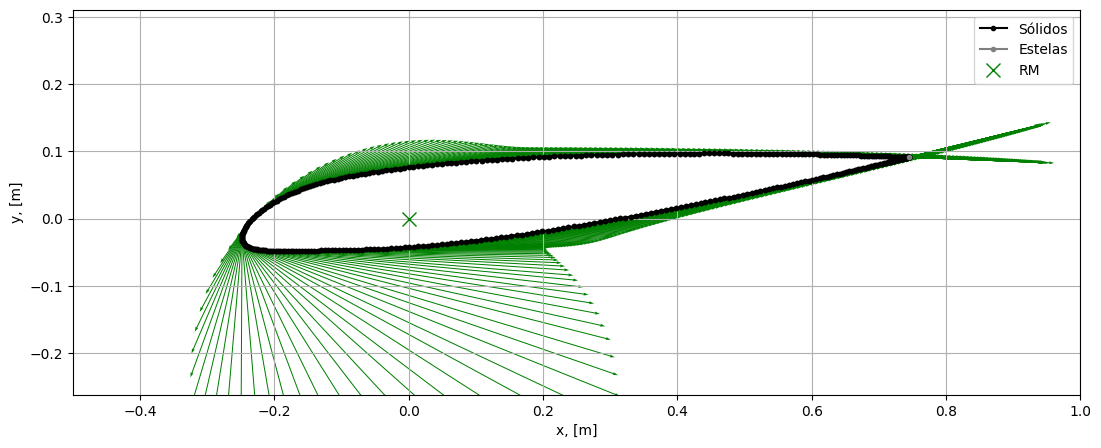

In [11]:
fig, axs = plt.subplots(1, 1, figsize=(13, 5))
mp.plotV(0, axs, escala=0.25, VRel=True)
mp.plotPaneles(0, axs, mostrarRM=True)
axs.set_xlim(-0.5, 1)
plt.show()

## Polares

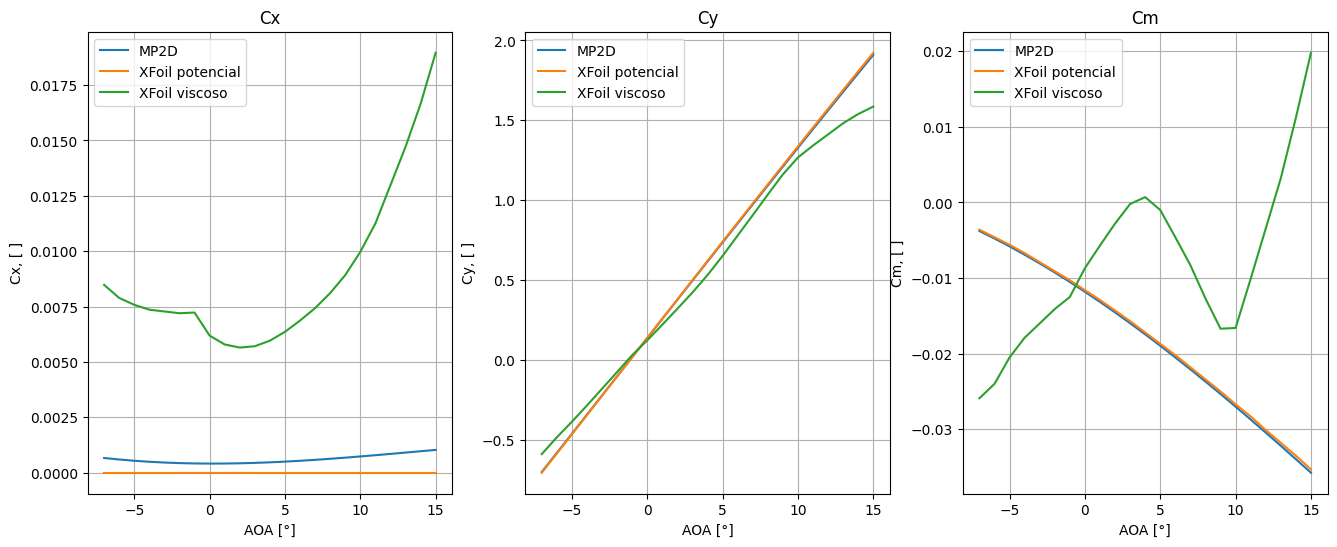

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(16,6))

# Se grafican las polares obtenidas con MP2D
ax = mp.plotCAero(ax)

# Se grafican las polares obtenidas con XFoil
xfoil = polaresXFoil('rec/NACA23012.pol')
xfoil_viscoso = polaresXFoil('rec/NACA23012_viscoso.pol')

ax[0].plot(xfoil['alfa'], xfoil['Cd'], label='XFoil potencial')
ax[1].plot(xfoil['alfa'], xfoil['Cl'], label='XFoil potencial')
ax[2].plot(xfoil['alfa'], xfoil['Cm'], label='XFoil potencial')

ax[0].plot(xfoil_viscoso['alfa'], xfoil_viscoso['Cd'], label='XFoil viscoso')
ax[1].plot(xfoil_viscoso['alfa'], xfoil_viscoso['Cl'], label='XFoil viscoso')
ax[2].plot(xfoil_viscoso['alfa'], xfoil_viscoso['Cm'], label='XFoil viscoso')

ax[0].legend()
ax[1].legend()
ax[2].legend()

plt.show()

Como en este caso la velocidad relativa al fluido en reposo tiene dirección $x^+$, el coeficiente $C_x$ se corresponde con el $C_d$ y el $C_y$ con el $C_l$.

En los gráficos precedentes se muestran los resultados del simulador desarrollado junto con los obtenidos con *XFoil*, tanto en su modo no viscoso como viscoso.

Se puede observar que:
- Las diferencias entre los $C_l$ y $C_m$ de los métodos potenciales son casi imperceptibles.
	
- Los coeficientes aerodinámicos en el problema viscoso difieren sustancialmente de aquellos obtenidos en el potencial. Esto es esperable y el grado de discrepancia depende fuertemente del perfil y las condiciones del experimento.
	
- El $C_d$ predicho por el simulador es mucho menor que el parásito mostrado.
	
	Sin embargo, el $C_d$ en flujo potencial es nulo en flujo estacionario, pero la curva `MP2D` no muestra esto.
	
	Esto se atribuye a la discretización del perfil y la utilización de dobletes constantes como singularidades, que dificulta la representación de la continuidad de la distribución de singularidades, sobre todo hacia el borde de fuga como se muestra más adelante.
	
	Cambiando la densidad del panelado, se puede notar cómo cambia la magnitud de las curvas obtenidas. Esta falta de consistencia entre discretizaciones apoya la idea de que la presencia de un $C_d$ no nulo es artefacto numérico del método.

## $C_p$

Seguidamente se muestra la distribución de $C_p$ obtenidas con el *solver* propio y *XFoil* no viscoso.

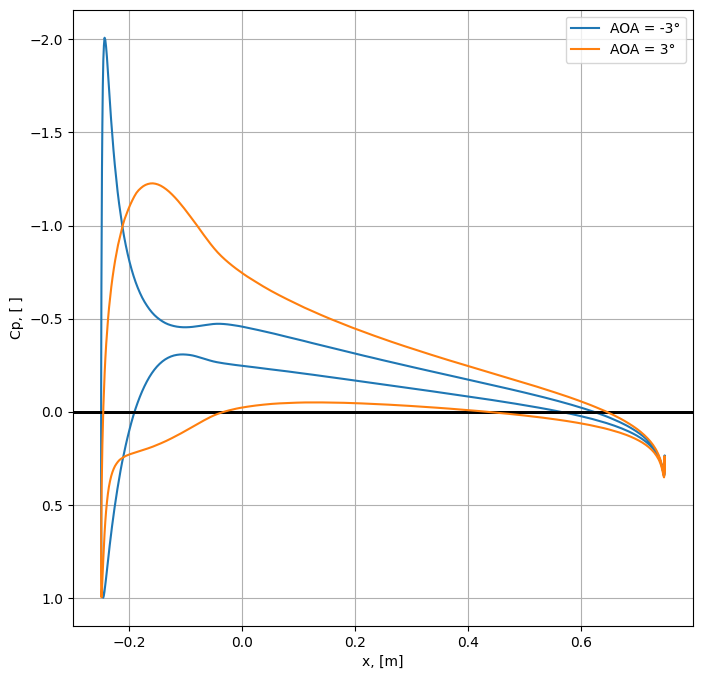

In [13]:
alfas = [-3, 3]
idc = np.where((alfa == alfas[0]) | (alfa == alfas[1]))[0]

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

mp.plotCp(idc[0], ax)
mp.plotCp(idc[1], ax)

lines = ax.get_lines()[1:4:2]
labels = [f'AOA = {alfas[0]}°', f'AOA = {alfas[1]}°']
ax.legend(lines, labels)

plt.show()

<img src="rec/xfoil_NACA23012_Cp_-3_3.png" alt="xfoil Cp -3 3" style="width:70%;"/>

También se puede apreciar una gran similitud en estas distribuciones.

## Observación

A menor número de paneles se acrecienta el defecto en el borde de fuga de la distrución obtenida.

Esto se debe al tipo de singularidad utilizada, que al considerar distribuciones de dobletes constantes en cada panel no queda bien representada la continuidad de la distribución real.

*XFoil* capta mejor el $C_p$ en el borde de fuga porque utiliza como singularidad distribuciones de vorticidad lineales, frente a dobletes constantes equivalente a vórtices puntuales que en este trabajo se utilizan. Esto sí permite captar la continuidad, evaluar la velocidad inducida sobre cualquier punto de la superficie, pues ya no hay vórtices puntuales que dejan indeterminada la velocidad hacia los nodos y, además, deja definida sin necesidad de realizar diferencias finitas la discontinuidad del salto de velocidad tangencial en los paneles, por \ref{Ec: distribución de vórtices límite u}.

Siguiendo, durante la realización de esta comparativa se detectó que partir de una mejor lista de coordenadas de los perfiles es menester para obtener resultados satisfactorios. 

Por lo anterior está claro que discretizaciones más densas producen mejores resultados. Sin embargo, si se cuenta con pocas coordenadas del perfil, refinar excesivamente el panelado no produce el efecto deseado, ya que los paneles comienzan a tener que segmentarse sin introducir más curvatura, lo que fuerza al fluido a seguir trayectorias menos suaves e introduce defectos como curvas de $C_p$ con dientes de sierra y polares degeneradas.

Entonces, para poder mejorar los resultados, debe refinarse el panelado y para esto debe contarse con suficientes coordenadas de los perfiles bajo estudio.

## Conclusión

Con esto, se considera que la implementación desarrollada brinda resultados a problemas estacionarios monoelemento, semejantes a los proporcionados por el programa *XFoil* en modo potencial, con las particularidades en cuanto al panelado indicadas.

A continuación, se ejemplifican más funcionalidades.

## Cp Vectorial

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


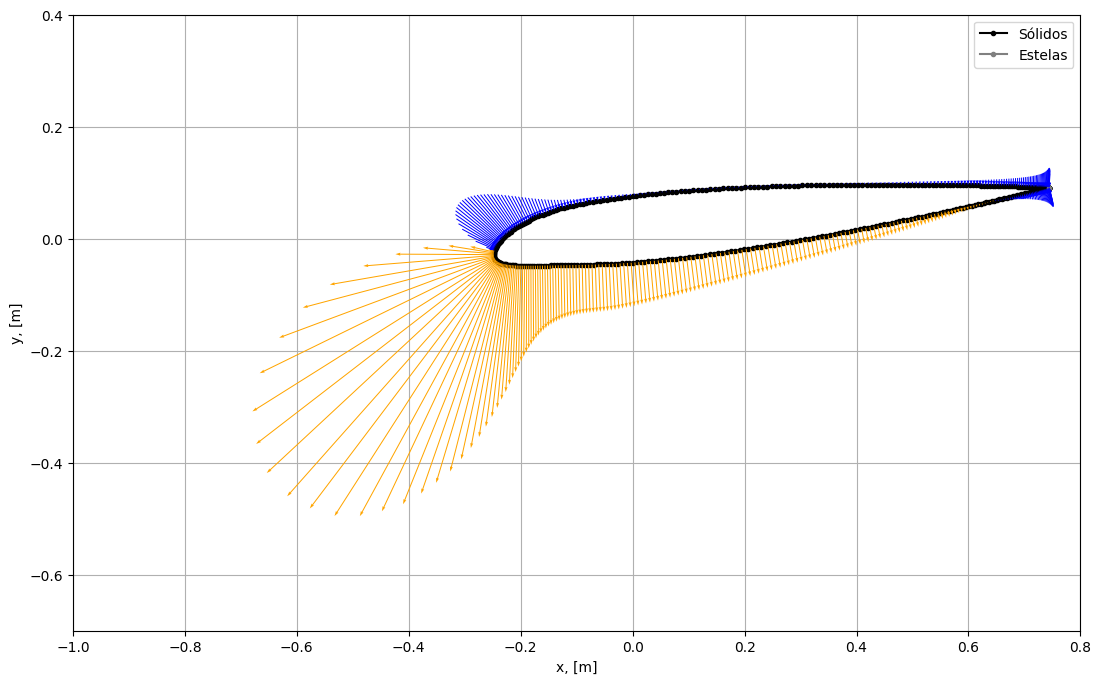

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(13,8))
mp.plotCpVect(0, ax, escala=0.1)
ax.set_xlim(-1, 0.8)
ax.set_ylim(-0.8, 0.5)
plt.show()

## Campo de $C_p$

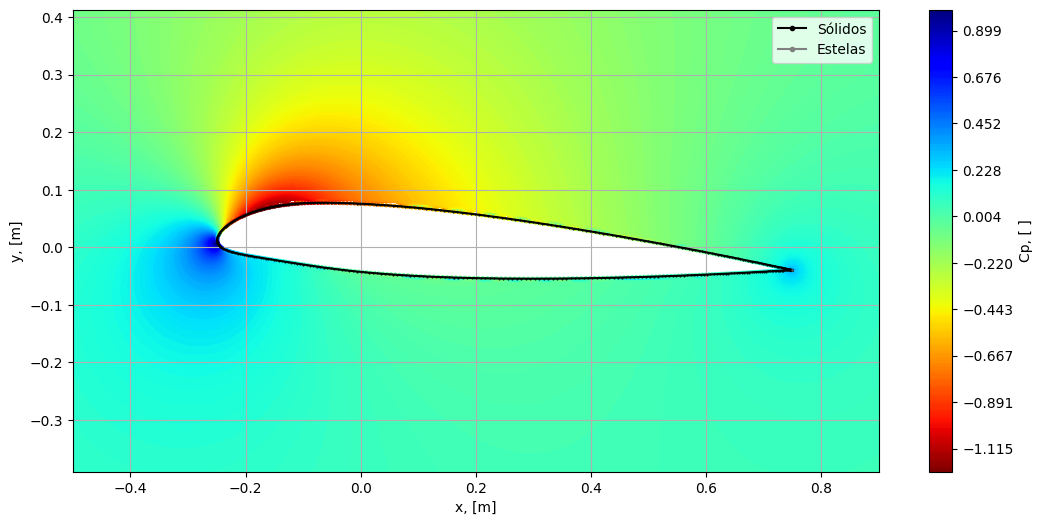

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(13, 6))
x = np.linspace(-0.6, 1.1, 250)
y = np.linspace(-0.4, 0.5, 250)
mp.plotCampo_Cp(10, x, y, ax=ax)

ax.set_xlim(-0.5, 0.9)
plt.show()

Sobre este tipo de gráficos se comenta más en el [ejemplo ala-flap](ejemploAlaFlap.ipynb#campo-de-cp).

## Guardado de los resultados para su uso en *Matlab*

Una vez realizadas simulaciones, pueden almacenarse los resultados de la simulación en un archivo `.mat` para ser utilizados en *Matlab*.

Para ejemplificar esto, además se incluye el [ejemplo en *Matlab*](ejemploBase.m).

In [24]:
mp.guardar_resultados('rec/ejemploBase', 'mat')

## Números de condición y métodos de resolución del SEL

A continuación se calcula múltiples veces el tiempo de simulación total de lo anterior empleando diferentes métodos de resolución del SEL, para calcular medias y desvíos estándar muestrales. A su vez, se calcula la norma $||Ax - b||$ con los diferentes métodos para comparar las soluciones obtenidas.

Con 100 repeticiones, se obtuvo:
La simulación con el método 'svd' tardó en promedio 0.9570505356788636 s en realizarse, con un desvío estándar muestral de 0.00602267632564402 s.
La simulación con el método 'qr' tardó en promedio 0.8134889101982117 s en realizarse, con un desvío estándar muestral de 0.005652315160157208 s.
El método 'lu' dio un warning de mala condición en la matriz de coeficientes.


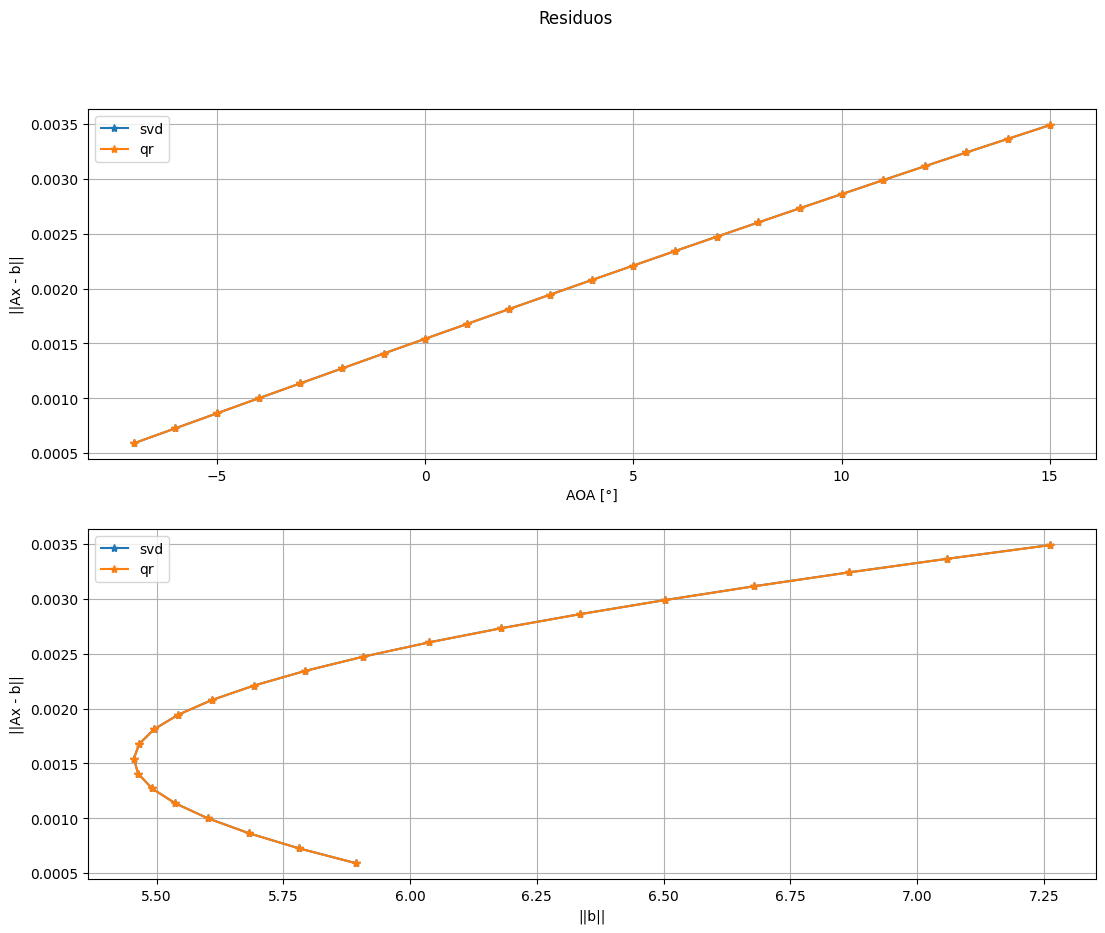

In [25]:
from time import time
def comparacionSELSol(metodo, rep):
    mpConfig['SELSol'] = metodo
    mpConfig['SELInfo'] = True

    mpConfig['mostrarProgreso'] = False

    tiempos = []

    for _ in range(rep):
        inicio = time()
        cinematica = Cinematicas.cinematica('aoa', AOAParams)
        RM = Cinematicas.RM('RM', RMParams)

        mp = MP2D(cinematica, RM, mpConfig, refConfig)
        mp.simular()

        tiempos.append(time() - inicio)
    
    tiempoMedio = np.mean(tiempos)
    tiempostd = np.std(tiempos, ddof=1)

    return mp.SELInfo['normaRes'], mp.SELInfo['normaInd'], mp.SELInfo['nCond'], tiempoMedio, tiempostd

metodos = ['svd', 'qr', 'lu']
rep = 100

figRes, axRes = plt.subplots(2, 1, figsize=(13, 10))
print(f"Con {rep} repeticiones, se obtuvo:")
for metodo in metodos:
    try: 
        with warnings.catch_warnings():
            warnings.filterwarnings("error", category=LinAlgWarning)
            
            res, ind, nCond, tiempoMedio, tiempostd = comparacionSELSol(metodo, rep)
            axRes[0].plot(alfa, res, '-*', label=metodo)
            axRes[1].plot(ind, res, '-*', label=metodo)
            print(f"La simulación con el método '{metodo}' tardó en promedio {tiempoMedio} s en realizarse, con un desvío estándar muestral de {tiempostd} s.")
    except LinAlgWarning:
        print(f"El método '{metodo}' dio un warning de mala condición en la matriz de coeficientes.")
    except RuntimeError:
        print(f"El método '{metodo}' no soportó la mala condición de la matriz de coeficientese. Probar con otro método.")
axRes[0].legend()
axRes[1].legend()

axRes[0].set_ylabel('||Ax - b||')
axRes[1].set_ylabel('||Ax - b||')

axRes[0].set_xlabel('AOA [°]')
axRes[1].set_xlabel('||b||')

figRes.suptitle('Residuos')
axRes[0].grid(True)
axRes[1].grid(True)
plt.show()

Se puede ver que la factorización LU brinda malos resultados o directamente falla, pues es particularmente susceptible al número de condición de la matriz de coeficientes. 
	
Entre QR y SVD no existen diferencias apreciables en la solución pero sí en el tiempo de ejecución: QR resultó en un tiempo de simulación total aproximadamente un 18\% menor sin sacrificar consistencia en el equipo utilizado.

Este tiempo de ejecución es el total de la simulación, es decir, incluyendo transformaciones de coordenadas, construcción del SEL en sí, etc. Entonces, la diferencia de rendimiento pura entre los métodos de resolución es en realidad mayor. Por este motivo, se decidió definir por defecto el uso de QR para resolver el SEL.

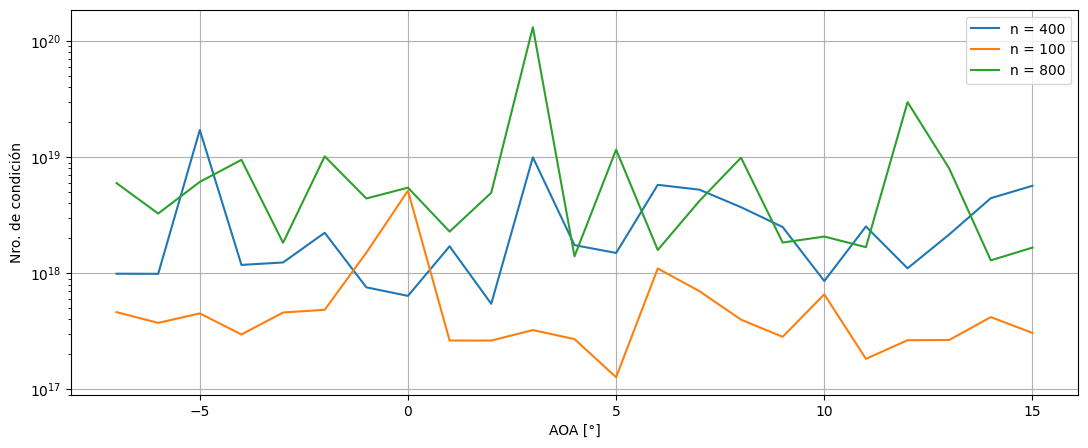

In [26]:
def nCond_nIntraExtra(ax, nIntraExtra):
    r_xy = discretizarPerfil(
        ruta = 'rec/perfiles/NACA23012_selig.txt',
        cuerda=c,
        nIntrados=nIntraExtra,
        nExtrados=nIntraExtra,
        formato='selig',
    )

    r_xy = Cinematicas.moverCoordenadas(r_xy, Dx = - 0.25 * c)
    AOAParams : Tipos.AOAParams = {
        'alfa' : alfa,
        'r_xy' : r_xy,
        'V' : V,
    }
    mpConfig['SELSol'] = 'qr'
    cinematica = Cinematicas.cinematica('aoa', AOAParams)
    RM = Cinematicas.RM('RM', RMParams)

    mp = MP2D(cinematica, RM, mpConfig, refConfig)
    mp.simular()


    ax.semilogy(alfa, mp.SELInfo['nCond'], label=f'n = {nIntraExtra * 2}')

fig, ax = plt.subplots(1, 1, figsize=(13, 5))
ax.semilogy(alfa, nCond, label=f'n = {nIntraExtra * 2}')

nn = [50, 400]

for n in nn:
    nCond_nIntraExtra(ax, n)

ax.legend()
ax.set_ylabel('Nro. de condición')
ax.set_xlabel('AOA [°]')
ax.grid(True)

Arriba se graficaron los números de condición que, aparte de ser altos e indicar matrices de coeficientes muy mal condicionadas, muestran que para un panelado más denso tienden a aumentar. Desde el punto de vista de la independencia de las filas de la matriz de coeficientes, cuando se refina la discretización, paneles contiguos son más similares entre sí en cuanto a la influencia que reciben de y la que producen en otros paneles, por lo que las ecuaciones de impenetrabilidad se correlacionan más y la matriz se asemeja más a una singular.

En [testArmonico.ipynb](testArmonico.ipynb) se amplía este análisis.